In [2]:
using Agents, Plots, LightGraphs, GraphRecipes, MetaGraphs, Random
include("src/a_star_cbs.jl")
include("src/warehouse.jl")

terminate_warehouse_sim (generic function with 1 method)

# Init Warehouse

49×49 SparseArrays.SparseMatrixCSC{Int64, Int64} with 48 stored entries:
⠢⡀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠢⠀⠀⠈⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠂⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠂⠀⠀⠀⠠⡀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠈⠀⠀⠀⠈⠢⡀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠈⠀⡀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠀⠢⡀⠀⠈⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠈⠢⠀⠀⠈⠀⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠠⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠈⠢⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀

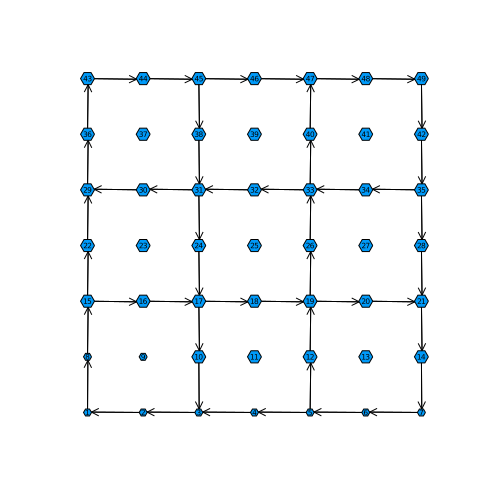

In [5]:
m,n = 3,3
g,p,d = generate_warehouse_struct(m,n,d_start=2,graph_type=SimpleDiGraph)
display(adjacency_matrix(g))
graphplot(Matrix(adjacency_matrix(g)),x=p[:,2],y=p[:,1],size=(500,500),curves=false,names=1:nv(g),fontsize=5)


In [6]:
function init_warehouse()
    Random.seed!(1234)

    ## Simulation 
    n_packages = 10
    load_spots = [8,12]
    package_list = rand(1:length(d),n_packages);

    warehouse_space = GraphSpace(g)
    model_props = Dict(:package_list=>package_list,
    :load_spot=>load_spots,
    :last_spot=> length(load_spots),
    :dest_spot=>d,
    :graph => g,
    :step => 1,
    :check_next_step => true,
    :used_load_spots=>zeros(Int,(length(load_spots))))

    warehouse = ABM(Robot, warehouse_space;properties= model_props)

    add_agent!(Robot(1,2,0,1,[]),2, warehouse)
    add_agent!(Robot(2,6,0,1,[]),6, warehouse)
    return warehouse, model_props
end

init_warehouse (generic function with 1 method)

In [7]:
factor = 2
warehouse,model_props = init_warehouse()
dest_spot_grid = model_props[:dest_spot].-(2*n+1)

robot_colors = (x,y)-> robot_colors_spots(x,y,model_props[:load_spot],dest_spot_grid)
robot_sizes = (x,y,z) -> robot_sizes_spots(x,y,z,model_props[:load_spot],model_props[:dest_spot],dest_spot_grid,factor)

cs=fill(0.05, nv(g), nv(g));

plot_warehouse = ()-> plotabm(warehouse;am=(x,y)->:rect,as=robot_sizes,ac=robot_colors,x=p[:,2],y=p[:,1],curves=false,curvature_scalar=cs,size=(750,750),linealpha=0.5,markerstrokewidth=0.0)

pl(model) = Vector(model.package_list);
adata = [:pos, :dest,:head]
mdata =[:last_spot,pl];

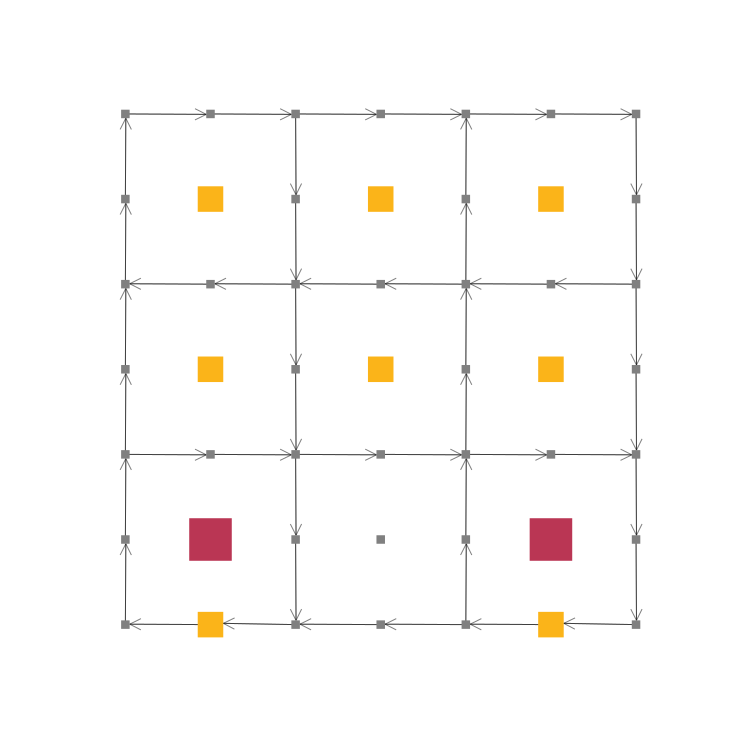

In [8]:
plot_warehouse()

## CBS Warehouse Step

In [9]:
function warehouse_step_cbs!(model)

    replan = false
    
    #TODO collision test
    
    for robot in allagents(model)
#         display(robot)
        if robot.dest == 0
            replan = true
            if robot.pos in model.load_spot && !isempty(model.package_list)# nalozeni
                next_package_dest = popfirst!(model.package_list)
                robot.dest = model.dest_spot[next_package_dest]
            elseif robot.pos in model.dest_spot || model.step == 1 #vylozeni
                robot.dest = get_load_spot(model)                
            end                                                                        
        end
#         display(robot)
    end
    
    if replan
         
        et = edgetype(model.graph)
        n_agents = nagents(model)

        constraints = init_constraints(n_agents,et)
        paths = [a_star(model.graph, robot.pos,robot.dest) for robot in [getindex(model,idx) for idx in 1:n_agents]]
        root= CBSNode(constraints,paths,length.(paths))

        solution = cbs(root,model.graph)
        for i in 1:n_agents
            robot = getindex(model,i)
            robot.path = solution[i]
        end
#         display(solution)

    end
    
    model.step += 1
end;

In [26]:
function robot_step_cbs!(robot,model)    
    if !isempty(robot.path)        
        next_step = robot.path[1].dst
        move_agent!(robot,next_step,model)
        popfirst!(robot.path)
    end
    
    if (robot.dest == robot.pos) && (robot.pos in model.dest_spot || (robot.pos in model.load_spot && !isempty(model.package_list)))
        robot.dest = 0        
    end
end;

In [31]:
# function terminate_warehouse_sim(model, step)
    
#     # for a in allagents(model)
#     #     if a.dest != 0
#     #         return false
#     #     end
#     # end    
#     # if isempty(model.package_list)
#     #     return true
#     # else
#     #     return false
#     # end
#     if isempty(model.package_list) & all([!(agent.dest in model.dest_spot)  for agent in allagents(model)])
#         return trueahlédni do logistických procesů například v těchto oblastech: Plánování logistiky, Operativní logistika, Předsériová logistika aj.

        
#     else
#         return false
#     end
# end

terminate_warehouse_sim (generic function with 1 method)

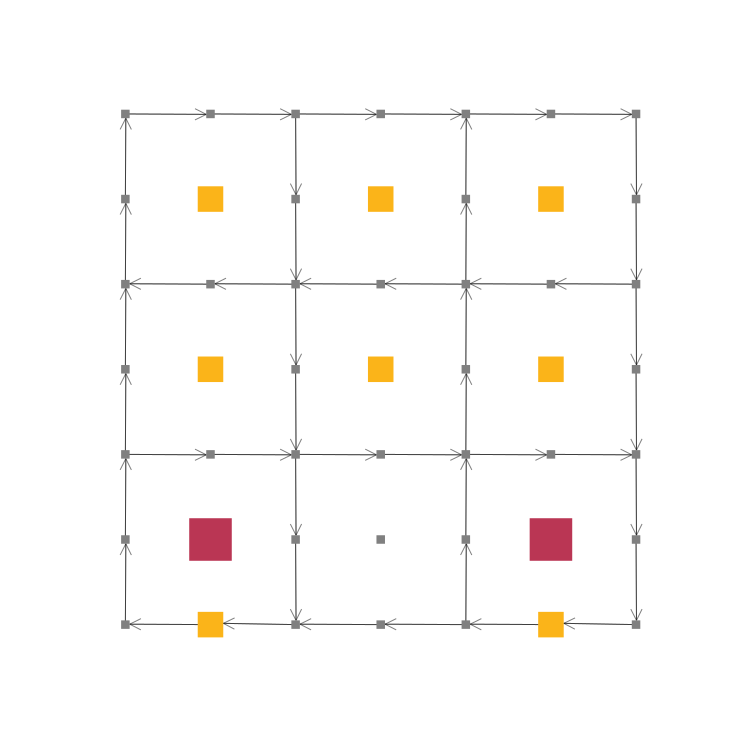

In [11]:
plot_warehouse()

In [329]:
warehouse.step

320740

In [27]:
warehouse,_ = init_warehouse()
adf, mdf = run!(warehouse, robot_step_cbs!,warehouse_step_cbs!,terminate_warehouse_sim;adata=adata,mdata=mdata, agents_first=false)

(246×5 DataFrame
 Row │ step   id     pos    dest   head  
     │ Int64  Int64  Int64  Int64  Int64 
─────┼───────────────────────────────────
   1 │     0      1      2      0      1
   2 │     0      2      6      0      1
   3 │     1      1      1     12      1
   4 │     1      2      5      8      1
   5 │     2      1      8     12      1
   6 │     2      2      4      8      1
   7 │     3      1     15     12      1
   8 │     3      2      3      8      1
   9 │     4      1     16     12      1
  10 │     4      2      2      8      1
  11 │     5      1     17     12      1
  ⋮  │   ⋮      ⋮      ⋮      ⋮      ⋮
 237 │   118      1     36     46      1
 238 │   118      2     38      8      1
 239 │   119      1     43     46      1
 240 │   119      2     31      8      1
 241 │   120      1     44     46      1
 242 │   120      2     24      8      1
 243 │   121      1     45     46      1
 244 │   121      2     17      8      1
 245 │   122      1     46      0      

In [14]:
ahlédni do logistických procesů například v těchto oblastech: Plánování logistiky, Operativní logistika, Předsériová logistika aj.warehouse.step

115

In [16]:
terminate_warehouse_sim(warehouse,1)

true

In [28]:
warehouse,_ = init_warehouse()
n_agents = nagents(warehouse)
display(warehouse.properties)
anim = @animate for i in 0:120
    step!(warehouse, robot_step_cbs!,warehouse_step_cbs!, 1,true)
    p1 = plot_warehouse()
    title!(p1, "step:$(i),packages to dispatch:$(length(warehouse.properties[:package_list]))")   
    if terminate_warehouse_sim(warehouse,i)
        # gif(anim, "warehouse_$(m)_$(n)_$(n_agents).mp4", fps = 4)
        break
    end    
    
end
gif(anim, "cbs_directed_warehouse_$(m)_$(n)_$(n_agents).mp4", fps = 4);
print(warehouse.step)

Dict{Symbol, Any} with 8 entries:
  :load_spot       => [8, 12]
  :graph           => {49, 48} directed simple Int64 graph
  :last_spot       => 2
  :step            => 1
  :used_load_spots => [0, 0]
  :package_list    => [3, 4, 6, 4, 1, 3, 6, 1, 1, 5]
  :dest_spot       => [30, 32, 34, 44, 46, 48]
  :check_next_step => true

122

┌ Info: Saved animation to 
│   fn = /home/datalab/projects/agents/warehouse/cbs_directed_warehouse_3_3_2.mp4
└ @ Plots /home/datalab/.julia/packages/Plots/oZheM/src/animation.jl:104
